# Advanced Machine Learning
## Deep Reinforcement Learning

&copy; Helena Aidos, 2024

### 1. Introduction

Deep Reinforcement Learning (RL) can be computationally expensive, data-intensive, and prone to stability issues during training. However, advancements in algorithms, hardware, and techniques (e.g., distributed RL, transfer learning) continually improve its practicality and effectiveness. Thus, Deep RL is a powerful framework for solving problems where explicit programming or rule-based approaches fall short, making it a cornerstone of modern AI research and development.

This notebook presents a framework for **Deep RL using JAX**, a library for array-oriented computation, with automatic differentiation and JIT compilation to enable high-performance machine learning research.

To be able to run this notebook, make sure that you have installed the following packages:
* jax (you probably installed it previously in TP6)
* optax (you probably installed it previously in TP6)
* gymnax
* flax
* distrax
* chex

If some of these packages are missing, you can install them the usual way. For instance, if you need to install `gymnax`, then
```python
!pip install gymnax
```

In [4]:
#pip install gymnax flax distrax chex

### 2. Deep Q Network

#### 2.1. Why do we need deep reinforcement learning?

Simply put, Q-learning is an **off-policy** algorithm (the target policy is not the policy used for decision-making) that maintains and updates a Q-table, an explicit mapping of states to corresponding action values.

While Q-learning is a practical solution for environments with discrete action spaces and restricted observation spaces, it struggles to scale well to more complex environments. Indeed, creating a Q-table requires **defining
the action and observation spaces**.

Consider the example of autonomous driving, the observation space is composed of an infinity of potential configurations derived from camera feeds and other sensory inputs. On the other hand, the action space
includes a wide spectrum of steering wheel positions and varying levels of force applied to the brake and accelerator.

Even though we could theoretically discretize the observation and action spaces, the sheer volume of possible states and actions leads to an **impractical Q-table** in real-world applications.

Finding optimal actions in large and complex state-action spaces thus requires **powerful function approximation algorithms**, which is precisely what Neural Networks are. In the case of Deep Reinforcement Learning, neural nets are used as a replacement for the Q-table and provide an efficient solution to the curse of dimensionality introduced by large state spaces. Furthermore, we do not need to define the observation space explicitly.

**Deep Reinforcement Learning (Deep RL) combines the strengths of deep learning and reinforcement learning**, enabling agents to learn complex behaviors and decision-making in environments with high-dimensional state and action spaces. Here's why Deep RL is valuable:

1. **Handling High-Dimensional Inputs:** Traditional RL struggles with raw, unprocessed inputs like images or sensor data. Deep RL leverages deep neural networks to extract meaningful features from such inputs, making it effective for tasks like robotics, video games, and autonomous driving.
2. **Learning Complex Policies:** Deep RL can learn sophisticated policies and strategies directly from data, even in environments with complex dynamics, sparse rewards, or long-term dependencies.
3. **Generalization Across Tasks:** By using deep networks, agents can generalize better to unseen states or variations within the environment, allowing them to adapt to slightly different but related scenarios.
4. **Scalability:** Deep RL scales well with modern computational resources and architectures, enabling the training of agents in expansive, continuous, or multi-agent environments.
5. **Exploration and Adaptation:** Deep RL agents can explore their environment and adapt their behavior over time, making it suitable for dynamic and uncertain real-world problems.
6. **End-to-End Learning:** Deep RL often requires minimal manual feature engineering, as neural networks learn the necessary representations directly from data, simplifying the workflow.

#### 2.2. Deep Q-networks (DQN)

DQN uses two types of neural networks in parallel, starting with the "online" network, which is used for **Q-value prediction** and **decision-making**. On the other hand, the "target" network is used to **create stable Q-targets** to assess the performance of the online net via the loss function.

Similarly to Q-learning, DQN agents are defined by two functions: `act` and `update`.

##### 2.2.1. Act

The `act` function implements an epsilon-greedy policy with respect to Q-values, which are estimated by the online neural network. In other words, the agent selects the action corresponding to the **maximum predicted Q-value** for a given state, with a set probability of acting randomly.

You might remember that Q-learning updates its Q-table **after every step**. However, in Deep Learning, it is common practice to compute updates using **gradient descent on a batch of inputs**.

For this reason, DQN stores experiences (tuples containing `state`, `action`, `reward`, `next_state`, `done_flag`) in a **replay buffer**. Instead of using only the last experience, we sample a batch of experiences from this buffer to train the network.

<img src="DQN_action_selection.png" alt='DQN_action_selection.png' width="500"/>

##### 2.2.2. Update

The `update` function is responsible for training the network. It computes a **mean squared error** (MSE) loss based on the **temporal-difference** (TD) error:
$$L(\theta)=E\left[ (r+(1-done) \times \gamma \max_{a'} Q(s',a';\theta^-) - Q(s,a;\theta))^2 \right]$$

In this loss function, $\theta$ denotes the **parameters of the online network**, and $\theta^-$ represents the **parameters of the target network**. The parameters of the target network are set on the online network's parameters every $N$ steps, similar to a *checkpoint* ($N$ is a hyperparameter).

This separation of parameters (with $\theta$ for the current Q-values and $\theta^-$ for the target (Q-values)) is crucial to stabilize training. Using the same parameters for both would be similar to aiming at a moving target, as updates to the network would immediately shift the target values. By **periodically updating** $\theta^-$ (i.e., freezing these parameters for a set number of steps), we ensure **stable Q-targets** while the online network continues to learn.

Finally, the $(1-done)$ term **adjusts the target for terminal states**. Indeed, when an episode ends (i.e., "done" is equal to 1), there is no next state. Therefore, the Q-value for the next state is set to 0.

<img src="DQN_parameter_update.png" alt='DQN_parameter_update.png' width="600"/>


#### 2.3. Replay buffers

They are widely used in reinforcement learning for a variety of reasons:

* **Generalization:** By sampling from the replay buffer, we break the correlation between consecutive experiences by mixing up their order. This way, we avoid overfitting to specific sequences of experiences.
* **Diversity:** As the sampling is not limited to recent experiences, we generally observe a lower variance in updates and prevent overfitting to the latest experiences.
* **Increased sample efficiency:** Each experience can be sampled multiple times from the buffer, enabling the model to learn more from individual experiences.

### 3. Gymnax environments

`gymnax` (documentation [here](https://pypi.org/project/gymnax/)) enhances the classic Gym API with the efficiency of JIT compilation and the scalability of vmap/pmap. It offers a diverse suite of environments, including classic control tasks, bsuite, MinAtar, and various classic/meta RL challenges. Gymnax provides precise functional control over environment settings, such as random seeds and hyperparameters, enabling faster and parallelized rollouts across different configurations—ideal for applications like meta-reinforcement learning.

In [5]:
import gymnax

You can get an overview of all implemented environments as follows:

In [6]:
gymnax.registered_envs

['CartPole-v1',
 'Pendulum-v1',
 'Acrobot-v1',
 'MountainCar-v0',
 'MountainCarContinuous-v0',
 'Asterix-MinAtar',
 'Breakout-MinAtar',
 'Freeway-MinAtar',
 'SpaceInvaders-MinAtar',
 'Catch-bsuite',
 'DeepSea-bsuite',
 'MemoryChain-bsuite',
 'UmbrellaChain-bsuite',
 'DiscountingChain-bsuite',
 'MNISTBandit-bsuite',
 'SimpleBandit-bsuite',
 'FourRooms-misc',
 'MetaMaze-misc',
 'PointRobot-misc',
 'BernoulliBandit-misc',
 'GaussianBandit-misc',
 'Reacher-misc',
 'Swimmer-misc',
 'Pong-misc']

#### 3.1. Cart Pole environment

In [7]:
import jax

rng = jax.random.PRNGKey(0)
rng, key_reset, key_policy, key_step = jax.random.split(rng, 4)

# create the CartPole-v1 environment
env, env_params = gymnax.make('CartPole-v1')
# inspect default environment settings
env_params

EnvParams(max_steps_in_episode=500, gravity=9.8, masscart=1.0, masspole=0.1, total_mass=1.1, length=0.5, polemass_length=0.05, force_mag=10.0, tau=0.02, theta_threshold_radians=0.20943951023931953, x_threshold=2.4)

`gymnax` is similar to `gymnasium`. Let's take a look to the CartPole-v1 environment (documentation [here](https://gymnasium.farama.org/environments/classic_control/cart_pole/)).

In [8]:
# observation space dimensionality
env.observation_space(env_params).shape

(4,)

In [9]:
# action space dimensionality
env.action_space(env_params).n

2

In [10]:
# alternatively, action space dimensionality
env.num_actions

2

In [11]:
obs, state = env.reset(key_reset, env_params)
obs, state

(Array([-0.02422718, -0.00036004, -0.04028944, -0.03402792], dtype=float32),
 EnvState(time=Array(0, dtype=int32, weak_type=True), x=Array(-0.02422718, dtype=float32), x_dot=Array(-0.00036004, dtype=float32), theta=Array(-0.04028944, dtype=float32), theta_dot=Array(-0.03402792, dtype=float32)))

In [12]:
action = env.action_space(env_params).sample(key_policy)
n_obs, n_state, reward, done, _ = env.step(key_step, state, action, env_params)
n_obs, n_state, reward, done

/home/joao/jupyter/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


(Array([-0.02423438, -0.19488175, -0.04097   ,  0.24567594], dtype=float32),
 EnvState(time=Array(1, dtype=int32, weak_type=True), x=Array(-0.02423438, dtype=float32), x_dot=Array(-0.19488175, dtype=float32), theta=Array(-0.04097, dtype=float32), theta_dot=Array(0.24567594, dtype=float32)),
 Array(1., dtype=float32, weak_type=True),
 Array(False, dtype=bool))

You can also simply use the environment with its default settings:

In [13]:
obs, state = env.reset(key_reset)
action = env.action_space().sample(key_policy)
n_obs, n_state, reward, done, _ = env.step(key_step, state, action)

/home/joao/jupyter/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


`gymnax` provides fully functional environment dynamics that can leverage the full power of JAX's function transformations. E.g. one common RL use-case the parallel rollout of multiple workers. Using a `vmap` across random seeds (one per worker) allows us to implement such a parallelization on a single machine:

In [14]:
vmap_reset = jax.vmap(env.reset, in_axes=(0, None))
vmap_step = jax.vmap(env.step, in_axes=(0, 0, 0, None))

num_envs = 8
vmap_keys = jax.random.split(rng, num_envs)

obs, state = vmap_reset(vmap_keys, env_params)
n_obs, n_state, reward, done, _ = vmap_step(vmap_keys, state, jax.numpy.zeros(num_envs), env_params)
print(n_obs.shape)

(8, 4)


### 4. Reinforcement Learning with JAX

`RLinJAX` is a library of deep reinforcement learning (RL) algorithms which you can `jax.jit` and `jax.vmap`. This notebook will show you how to set up, train and evaluate deep RL agents.

The library has implemented several deep reinforcement learning algorithms, such as:
* `dqn` - deep Q-network
* `iqn` - implicit quantile network
* `ppo` - proximal policy optimization
* `pqn` - pointer Q-network
* `sac` - soft actor-critic
* `td3` - twin delayed DDPG (deep deterministic policy gradients)

In [15]:
import time
from RLinJAX import *

2024-12-16 14:51:10.148053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734360670.295466   16194 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734360670.337005   16194 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
jax.devices()

[CpuDevice(id=0)]

#### 4.1. Setting up the training configuration

There are different types of parameters: environment, common, and algorithm-specific. These parameters can be setup using a dictionary.
* **Environment parameters** are specific to the environment and include the maximum number of steps per episode, `max_steps_in_episode` (default: depends on the environment considered; 500 for the CartPole-v1 environment).
* **Common parameters** are general parameters in common with all the implemented algorithms, and some are related to the training of the neural networks. The following are some of those parameters with the corresponding default values:
    * `batch_size` = 256
    * `learning_rate` = 0.0003
    * `polyak` = 0.99 (see this [link](https://arxiv.org/html/2404.07525v1) for explanation)
    * `num_epochs` = 1
    * `num_envs` = 1
    * `total_timesteps` = 131072 (corresponds to the number of episodes)
    * `eval_freq` = 4096
    * `target_update_freq` = 1
    * `buffer_size` = 131072
    * `fill_buffer` = 2048
    * `gamma` = 0.99
* **Algorithm-specific parameters** are specific to each algorithm (only presenting the two algorithms to be considered in the work):
    * Parameters specific to algorithms using the epsilon-greedy method:
        * `eps_start` = 1
        * `eps_end` = 0.05
        * `exploration_fraction` = 0.1 
    * `dqn`:
        * `agent` = "QNetwork" (another option is DuelingQNetwork)
        * `activation` = "swish"
        * `ddqn` = True (double deep q-network)
    * `sac`:
        * `activation` = "relu"
        *  `target_entropy_ratio` = 0.98
        *  `num_critics` = 2

Let's see an example of how to set these parameters for the `dqn` agent in the `CartPole-v1` environment.

In [17]:
CONFIGS = {"dqn":{"agent": "DuelingQNetwork",
                  "agent_kwargs": {"activation": "swish"},
                  #"num_envs": 10,
                  "buffer_size": 100_000,
                  "fill_buffer": 1_000,
                  "batch_size": 100,
                  "learning_rate": 0.0003,
                  "polyak": 0.98,
                  "num_epochs": 5,
                  "target_update_freq": 200,
                  "total_timesteps": 100_000,
                  "eval_freq": 5000,
                  "eps_start": 1,
                  "eps_end": 0.01,
                  "exploration_fraction": 0.5,
                  "gamma": 0.9,
                  "ddqn": True
                 }
          }

1. Each algorithm is represented as a class that extends `flax.PyTreeNode`
2. `get_algo` is a convenient function to access algorithms easily
3. `alg_cls.create` creates a frozen instance of the algorithm and populates it with default values

Let's create the algorithm instance for DQN in the CartPole-v1 environment:

In [18]:
algo_str = "dqn"
env_str = "CartPole-v1"

algo_cls = get_algo(algo_str)
algo = algo_cls.create(env=env_str, **CONFIGS.get(algo_str, {}))

Let's look at the algorithm instance we have created:

In [19]:
algo.config

{'env': <gymnax.environments.classic_control.cartpole.CartPole at 0x70323e6a12b0>,
 'env_params': {'max_steps_in_episode': 500,
  'gravity': 9.8,
  'masscart': 1.0,
  'masspole': 0.1,
  'total_mass': 1.1,
  'length': 0.5,
  'polemass_length': 0.05,
  'force_mag': 10.0,
  'tau': 0.02,
  'theta_threshold_radians': 0.20943951023931953,
  'x_threshold': 2.4},
 'eval_callback': <function RLinJAX.algos.algorithm.Algorithm.create.<locals>.eval_callback(algo, ts, rng)>,
 'eval_freq': 5000,
 'skip_initial_evaluation': False,
 'total_timesteps': 100000,
 'learning_rate': 0.0003,
 'gamma': 0.9,
 'max_grad_norm': inf,
 'normalize_observations': False,
 'target_update_freq': 200,
 'polyak': 0.98,
 'num_envs': 1,
 'buffer_size': 100000,
 'fill_buffer': 1000,
 'batch_size': 100,
 'eps_start': 1,
 'eps_end': 0.01,
 'exploration_fraction': 0.5,
 'agent': {'hidden_layer_sizes': (64, 64),
  'activation': <PjitFunction>,
  'action_dim': 2,
  'parent': None,
  'name': None},
 'num_epochs': 5,
 'ddqn': True

As you can see we have a lot of hyperparameters and variables we can tune. You are free to modify these after the creation, you just need to use the method `replace`.

In [20]:
algo = algo.replace(gamma=0.95)
print(f"New gamma: {algo.gamma}")

New gamma: 0.95


**A few words about configs**

1. In `RLinJAX`, algorithms extend `flax.struct.PyTreeNode`(documentation [here](https://flax.readthedocs.io/en/latest/api_reference/flax.struct.html)). this allows to `jit` (documentation [here](https://jax.readthedocs.io/en/latest/_autosummary/jax.jit.html#jax.jit)) and `vmap` (documentation [here](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html#jax.vmap)) over individual parameters while keeping others fixed. For example, you can vmap over `learning_rate`, but not over `total_timesteps`.
2. You are free to replace the config you pass to the training algorithm with any object that has the same (or necessary) attributes.

#### 4.2. Training the agent

In [21]:
# set training seed and jit train function
rng = jax.random.PRNGKey(0)
train_fn = jax.jit(algo.train)

print("Starting to train")
# Train
start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = algo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

Starting to train


/home/joao/jupyter/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/home/joao/jupyter/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 3.43099 seconds (29146.1 steps/second).


Whoa, that was pretty quick! Let's break down what just happened.

1. We jit `algo.train` to allow for fast execution
2. `algo.train` created an initial `train_state`, which holds information about the algorithm's current state, such as the current environment step, replay buffer contents, network parameters, and more.
3. The algorithm transforms the `train_state` during training. The final value of the `train_state`, including the final network parameters, is returned.
4. Additionally, the returned `evaluation` value is a tuple of episode lengths and episodic returns. Each element of this tuple has the shape `(total_timesteps / eval_freq + 1, num_seeds)`. The `+1` comes from the fact that we also evaluate the initial policy per default. You can change the parameter `skip_initial_evaluation` in the initial CONFIG to skip the initial policy. Beware that smaller values of `eval_freq` will produce episodic return plots with much noise.

In [22]:
print('Tuple size:', len(evaluation))
print('Episodic lengths and episodic returns shape:', evaluation[0].shape)
print(f"{algo.total_timesteps} / {algo.eval_freq} + 1 = {(algo.total_timesteps/algo.eval_freq+1)}" )

Tuple size: 2
Episodic lengths and episodic returns shape: (21, 128)
100000 / 5000 + 1 = 21.0


**Note:** Depending on your computer, the next instruction can take several minutes to run.

In [23]:
evaluation

(Array([[ 26,  40,  29, ...,  28,  28,  15],
        [  9,   9,  11, ...,  11,  10,  12],
        [  9,   9,  10, ...,   8,   8,  10],
        ...,
        [ 94,  99,  98, ...,  92,  93,  96],
        [ 97,  96,  95, ...,  98,  98,  92],
        [ 95, 241,  95, ...,  92,  94,  95]], dtype=int32, weak_type=True),
 Array([[ 26.,  40.,  29., ...,  28.,  28.,  15.],
        [  9.,   9.,  11., ...,  11.,  10.,  12.],
        [  9.,   9.,  10., ...,   8.,   8.,  10.],
        ...,
        [ 94.,  99.,  98., ...,  92.,  93.,  96.],
        [ 97.,  96.,  95., ...,  98.,  98.,  92.],
        [ 95., 241.,  95., ...,  92.,  94.,  95.]],      dtype=float32, weak_type=True))

Let's look at how well training worked by plotting the learning curve!

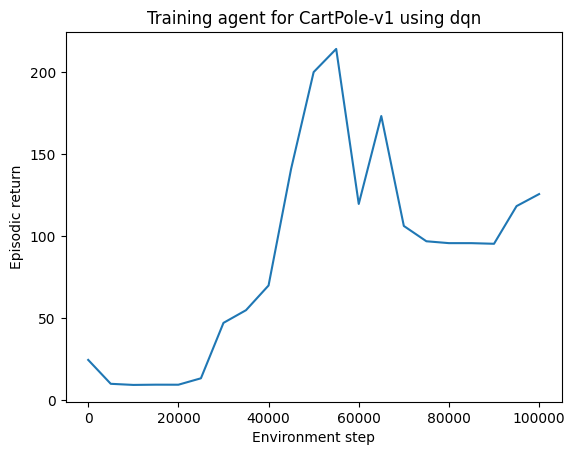

In [24]:
from matplotlib import pyplot as plt

episode_lengths, episode_returns = evaluation
mean_return = episode_returns.mean(axis=1)

plt.plot(jax.numpy.linspace(0, algo.total_timesteps, len(mean_return)), mean_return)
plt.xlabel("Environment step")
plt.ylabel("Episodic return")
plt.title(f"Training agent for {env_str} using {algo_str}")
plt.show()

We should also take a look at the `train_state`, to see what the algorithm produced.

In [25]:
jax.tree_util.tree_map(lambda x: x.shape, train_state).__dict__

{'rng': (2,),
 'env_state': EnvState(time=(1,), x=(1,), x_dot=(1,), theta=(1,), theta_dot=(1,)),
 'last_obs': (1, 4),
 'global_step': (),
 'last_done': (1,),
 'q_ts': TrainState(step=(), apply_fn=(), params={'params': {'Dense_0': {'bias': (1,), 'kernel': (64, 1)}, 'Dense_1': {'bias': (2,), 'kernel': (64, 2)}, 'MLP_0': {'Dense_0': {'bias': (64,), 'kernel': (4, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}}}}, tx=GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x70323e520f40>, update=<function chain.<locals>.update_fn at 0x70323e5239c0>), opt_state=(ScaleByAdamState(count=(), mu={'params': {'Dense_0': {'bias': (1,), 'kernel': (64, 1)}, 'Dense_1': {'bias': (2,), 'kernel': (64, 2)}, 'MLP_0': {'Dense_0': {'bias': (64,), 'kernel': (4, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}}}}, nu={'params': {'Dense_0': {'bias': (1,), 'kernel': (64, 1)}, 'Dense_1': {'bias': (2,), 'kernel': (64, 2)}, 'MLP_0': {'Dense_0': {'bias': (64,), 'kernel': (4, 64)}, 'Dense_1

In DQN algorithms, the `train_state` has a `q_ts` which is an instance of a `flax.training.train_state.TrainState` (documentation [here](https://flax.readthedocs.io/en/latest/api_reference/flax.training.html#flax.training.train_state.TrainState)). This provides the network parameters of our final agent. Note that while also being a `flax.struct.PyTree`, our `train_state` is not. Algorithms which use buffers also have a `replay_buffer` state.

#### 4.3. Making and evaluating policies

As discussed above, algorithms return an agent's policy parameters in its train state. We can extract a policy of the type `Callable[[chex.Array, chex.PRNGKey], chex..Array]` which maps `(obs, rng) -> action` like this:

In [26]:
policy = algo.make_act(train_state)
policy = jax.jit(policy)

Let's evaluate the policy! For demonstration purposes here is a full rollout like you would do with Gymnasium:

In [27]:
rng = jax.random.PRNGKey(0)
env, params = gymnax.make(env_str)
step = jax.jit(env.step)

obs, state = env.reset(rng, params)
episode_return = 0
done = False

while not done:
    rng, rng_action, rng_step = jax.random.split(rng, 3)
    action = policy(obs, rng_action)
    obs, state, reward, done, info = step(rng_step, state, action, params)
    episode_return += reward

print(f"Return achieved in one episode of {env_str}: {episode_return}")

Return achieved in one episode of CartPole-v1: 93.0


Alternatively, `RLinJAX` offers fast parallel evaluation of policies under the function `evaluate`:

In [28]:
from RLinJAX.evaluate import evaluate

num_seeds = 200  
max_steps = params.max_steps_in_episode

rng = jax.random.PRNGKey(0)

start = time.time()

# Evaluation time!
episode_lengths, episode_returns = evaluate(policy, rng, env, params, num_seeds, max_steps)

time_elapsed = time.time() - start

print(
    f"Evaluated {num_seeds} episodes "
    f"with a total of {jax.numpy.sum(episode_lengths)} environment steps "
    f"in {time_elapsed:g} seconds."
)

Evaluated 200 episodes with a total of 24316 environment steps in 1.26145 seconds.


[Text(0.5, 1.0, 'Episode return')]

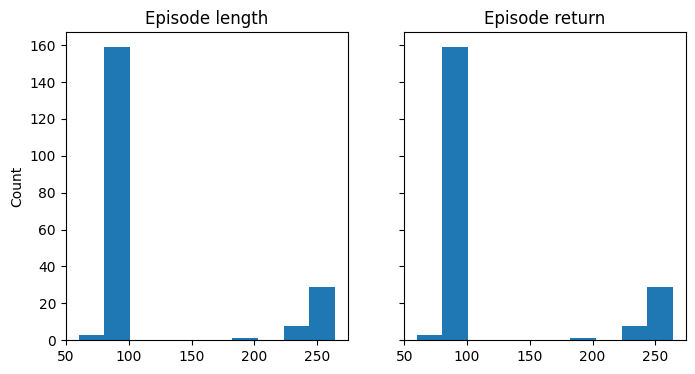

In [29]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2, sharey="row")

axes[0].hist(episode_lengths, bins=10)
axes[0].set(title="Episode length", ylabel="Count")
axes[1].hist(episode_returns)
axes[1].set(title="Episode return")